In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import open3d as o3d
from PIL import Image as im
import math
from scipy import ndimage

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Point cloud generation

In [4]:
DOWNSAMPLING = 50
MPIXEL = 0.05
PADDING = 50
BASE_DIR = "/scratch/scannet_data"


scenes = os.listdir(BASE_DIR+'/depths')
# scenes.sort()
for scene in scenes:

    print(f"Loading Scene : {scene} ... ")
    
    # LOADING CAMERA INTRINSIC MATRIX
    camera_intrinsics = np.loadtxt(BASE_DIR+'/intrinsics/'+scene+'/intrinsic_depth.txt')
    #print(camera_intrinsics)
    fx = camera_intrinsics[0][0]
    fy = camera_intrinsics[1][1]
    S = camera_intrinsics[0][1]
    cx = camera_intrinsics[0][2]
    cy = camera_intrinsics[1][2]
    print(camera_intrinsics)
    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx=fx,fy=fy,cx=cx,cy=cy)  
    
    # POINT CLOUD REGISTRATION
    
    scans_list = os.listdir(BASE_DIR+'/depths/'+scene)
    scans_list = list(map(lambda x: x.split('.')[0],scans_list))

    pcd_list = []
    for i,scan in enumerate(scans_list):
        depth_map = o3d.geometry.Image(np.ascontiguousarray(np.load(BASE_DIR+'/depths/'+scene+"/"+scan+'.npy')).astype(np.float32))
    #     rgb_img = cv2.resize(cv2.imread('./imgs/'+scene+'/'+scan+'.png'),(640,480))
    #     rgb_img = o3d.geometry.Image(rgb_img)
        mask = cv2.resize(cv2.imread(BASE_DIR+'/masks/'+scene+'/'+scans_list[i]+'.png'),(640,480))
        floor_segmentation = o3d.geometry.Image(np.asarray(np.isin(mask, [5])*254,dtype=np.uint8))
        rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(floor_segmentation), o3d.geometry.Image(depth_map),convert_rgb_to_intensity=False)
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
        pose = np.loadtxt(BASE_DIR+'/poses/'+scene+'/'+scan+'.txt',dtype=np.float32)
        pcd = pcd.transform(pose)
        pcd_list.append(pcd.uniform_down_sample(DOWNSAMPLING))
        

    # COMBINIG THE POINT CLOUD
    
    pcd_combined = o3d.geometry.PointCloud()
    for point_id in range(len(pcd_list)):
            pcd_combined += pcd_list[point_id]
#     o3d.io.write_point_cloud(BASE_DIR+"/pcds/"+scene+".pcd", pcd_combined)
    
    print(f"Registered point cloud  - total points :{len(pcd_combined.points)} for scene : {scene} ... ")    
    
    # READING THE POINT CLOUD
#     pcd = o3d.io.read_point_cloud(BASE_DIR+"/pcds/"+scene+".pcd")
    points = np.asarray(pcd_combined.points)
    colors = np.asarray(pcd_combined.colors)
    
    max_coordinates = np.nanmax(points,axis=0)
    min_coordinates = np.nanmin(points,axis=0)
    #print(max_coordinates,min_coordinates)
    
    bound = max(abs(max_coordinates[0]),abs(min_coordinates[0]),abs(max_coordinates[1]),abs(min_coordinates[1]))
    W = 2*math.ceil(bound/MPIXEL) + PADDING

    
    # GLOBAL OCCUPANCY MAP GENERATION
    p = np.copy(points)
    col = p[:,0]/MPIXEL + W/2
    row = W/2 - p[:,1]/MPIXEL 
    idx = row.astype(int)*W+col.astype(int)
    valid_idx = p[:,2]<1.5
    p = p[valid_idx]
    idx = idx[valid_idx]
    c = (colors[valid_idx,0]*255).astype(int)
    # print(np.sum(c==254))
    rank = np.argsort(idx)
    p = p[rank]
    c = c[rank]
    idx = idx[rank]
    keep = np.ones_like(idx).astype(int)
    keep[:-1] = idx[1:]!=idx[:-1]
    occ = np.cumsum(c==0)[keep==1]
    occ[1:] = occ[1:]-occ[:-1]
    ground = np.logical_and(c==254,p[:,2]<0.2)
    free = np.cumsum(ground)[keep==1]
    free[1:] = free[1:]-free[:-1]
    idx = idx[keep==1]
    occupancy_grid = np.zeros((W*W),dtype=np.float64)
    occupancy_grid[idx] = (occ/(occ+free+1e-6) > 0.5)+1
    occupancy_grid = occupancy_grid.reshape((W,W))
    
    print(f"Generated Occupancy Grid : {scene} ... \n")    
    occ_img = im.fromarray(np.asarray(occupancy_grid*124,dtype=np.uint8))
    if occ_img.mode != 'RGB':
        occ_img = occ_img.convert('RGB')
    occ_img.save("./Results/"+scene+'.jpeg')
    

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/scannet_data/depths'

### Individual scene

In [9]:
scene = "scene0005_01"
BASE_DIR = "."
DOWNSAMPLING = 50
MPIXEL = 0.05
PADDING = 50

In [10]:
camera_intrinsics = np.loadtxt(BASE_DIR+'/intrinsics/'+scene+'/intrinsic_depth.txt')
print(camera_intrinsics)
fx = camera_intrinsics[0][0]
fy = camera_intrinsics[1][1]
S = camera_intrinsics[0][1]
cx = camera_intrinsics[0][2]
cy = camera_intrinsics[1][2]

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx=fx,fy=fy,cx=cx,cy=cy)

[[577.870605   0.       319.5        0.      ]
 [  0.       577.870605 239.5        0.      ]
 [  0.         0.         1.         0.      ]
 [  0.         0.         0.         1.      ]]


In [11]:
scans_list = os.listdir(BASE_DIR+'/depths/'+scene)
scans_list = list(map(lambda x: x.split('.')[0],scans_list))

pcd_list = []
for i,scan in enumerate(scans_list):
    depth_map = o3d.geometry.Image(np.ascontiguousarray(np.load(BASE_DIR+'/depths/'+scene+"/"+scan+'.npy')).astype(np.float32))
#     rgb_img = cv2.resize(cv2.imread('./imgs/'+scene+'/'+scan+'.png'),(640,480))
#     rgb_img = o3d.geometry.Image(rgb_img)
    mask = cv2.resize(cv2.imread(BASE_DIR+'/masks/'+scene+'/'+scans_list[i]+'.png'),(640,480))
    floor_segmentation = o3d.geometry.Image(np.asarray(np.isin(mask, [5])*254,dtype=np.uint8))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d.geometry.Image(floor_segmentation), o3d.geometry.Image(depth_map),convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
    pose = np.loadtxt(BASE_DIR+'/poses/'+scene+'/'+scan+'.txt',dtype=np.float32)
    pcd = pcd.transform(pose)
    pcd_list.append(pcd.uniform_down_sample(DOWNSAMPLING))


In [12]:
pcd_combined = o3d.geometry.PointCloud()
for point_id in range(len(pcd_list)):
        pcd_combined += pcd_list[point_id]
o3d.io.write_point_cloud(BASE_DIR+"/pcds/"+scene+".pcd", pcd_combined)

True

In [13]:
pcd = o3d.io.read_point_cloud(BASE_DIR+"/pcds/"+scene+".pcd")
o3d.visualization.draw_geometries([pcd])

In [14]:
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

In [15]:
max_coordinates = np.max(points,axis=0)
min_coordinates = np.min(points,axis=0)
print(max_coordinates,min_coordinates)

[4.44382811 7.09614038 2.50098395] [-0.00128588  1.11176622 -0.03440472]


#### Occupancy map characteristics

In [16]:
mpixel = 0.05
padding = 50

bound = max(abs(max_coordinates[0]),abs(min_coordinates[0]),abs(max_coordinates[1]),abs(min_coordinates[1]))
W = 2*math.ceil(bound/mpixel) + padding

In [17]:
p = np.copy(points)
col = p[:,0]/mpixel + W/2
row = W/2 - p[:,1]/mpixel 
idx = row.astype(int)*W+col.astype(int)
valid_idx = p[:,2]<1.5
p = p[valid_idx]
idx = idx[valid_idx]
c = (colors[valid_idx,0]*255).astype(int)
# print(np.sum(c==254))
rank = np.argsort(idx)
p = p[rank]
c = c[rank]
idx = idx[rank]
keep = np.ones_like(idx).astype(int)
keep[:-1] = idx[1:]!=idx[:-1]
occ = np.cumsum(c==0)[keep==1]
occ[1:] = occ[1:]-occ[:-1]
ground = np.logical_and(c==254,p[:,2]<0.2)
free = np.cumsum(ground)[keep==1]
free[1:] = free[1:]-free[:-1]
idx = idx[keep==1]
occupancy_grid = np.zeros((W*W),dtype=np.float64)
occupancy_grid[idx] = (occ/(occ+free+1e-6) < 0.5)+1
occupancy_grid = occupancy_grid.reshape((W,W))

In [18]:
print(occupancy_grid.shape)

(334, 334)


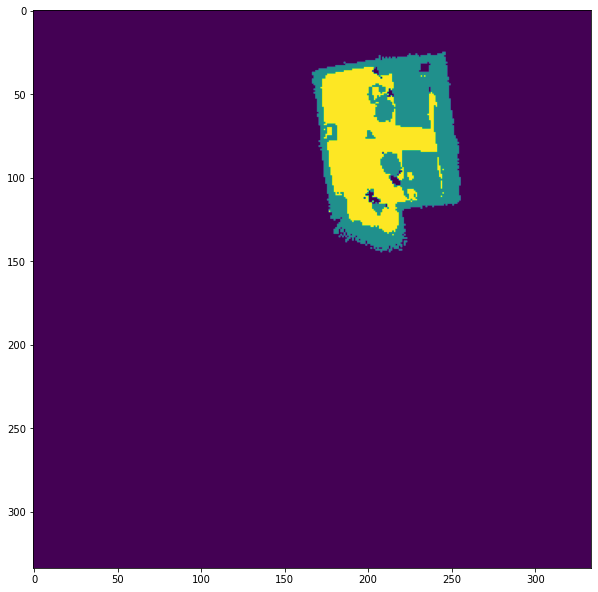

In [19]:
plt.figure(figsize=(10,15))
plt.imshow(np.asarray(occupancy_grid,dtype=np.uint8))

In [19]:
occ_img = im.fromarray(np.asarray(occupancy_grid*127,dtype=np.uint8))
if occ_img.mode != 'RGB':
    occ_img = occ_img.convert('RGB')
occ_img.save("./Results/"+scene+'.png')

In [21]:
cv2.imwrite("./Results/"+scene+'.png',occupancy_grid*127)

True

In [ ]:
properties = {
    "bounds":{
        "max_x":max_coordinates[0],
        "max_y":max_coordinates[1],
        "max_z":max_coordinates[2],
    }
}

# max, min, padding , resolution , downsampling , height thresholds 

### Per scan occupancy map generation

In [22]:
def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX,[0,0]], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False,order=0)
    return imgR,padY[0],padX[0]

def Rotation_to_Euler(R):
    yaw = np.arctan2(R[2][0],R[2][1])
    pitch = np.arccos(R[2][2])
    roll = -np.arctan2(R[0][2],R[1][2])
    return roll

In [28]:
poses = os.listdir(BASE_DIR+'/poses/'+scene)
img = cv2.imread('./Results/'+scene+'.png')
crop_resolution = 3.2
W = img.shape[0]//2
output_path = './Results/local/'+scene
if not os.path.exists(output_path):
    os.makedirs('./Results/local/'+scene, exist_ok=False)
for pose in poses:
    p = np.loadtxt(BASE_DIR+'/poses/'+scene+'/'+pose)
    x_disp = (p[0][3]//MPIXEL + img.shape[0]//2).astype(int)
    y_disp = (img.shape[0]//2 - p[1][3]//MPIXEL ).astype(int)
    roll = Rotation_to_Euler(p)
    roll = roll*(180/math.pi)
    res_img,pad_y,pad_x =rotateImage(img,-roll,[x_disp.astype(int),y_disp.astype(int)])
#     print(np.unique(res_img))
#     plt.figure(figsize=(10,15))
#     plt.subplot(1,2,1)
#     plt.imshow(res_img)
#     plt.plot(x_disp+pad_x,y_disp+pad_y,'o')
    # Cropping the occupancy map
    start_x = x_disp+pad_x-int((crop_resolution//MPIXEL)//2)
    end_x =  start_x + int(crop_resolution//MPIXEL)
    start_y = y_disp+pad_y - int(crop_resolution//MPIXEL)
    end_y = y_disp+pad_y
    local_occupancy_map = res_img[start_y:end_y,start_x:end_x,:]
#     plt.subplot(1,2,2)
#     print(local_occupancy_map.shape)
#     plt.imshow(local_occupancy_map)
#     occ_img = im.fromarray(local_occupancy_map)
#     plt.imshow(local_occupancy_map)
#     if occ_img.mode != 'RGB':
#         occ_img = occ_img.convert('RGB')
    cv2.imwrite("./Results/local/"+scene+'/'+pose.split('.')[0]+'.png',local_occupancy_map)
#     occ_img.save("./Results/local/"+scene+'/'+pose.split('.')[0]+'.png')

In [10]:
print(img.shape[0]*0.05)

16.7
